In [1]:
import dash 
from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc
from dash import html
from dash import dcc
from dash.dependencies import Output, Input

In [84]:
# app instantiation
app = JupyterDash(__name__, external_stylesheets=[dbc.themes.PULSE])

image_path = "assets/slrpEVlogo.png"

# app layout
app.layout = html.Div([
     html.Img(
        src=image_path, 
        height="100px", 
        style={'display': 'inlineBlock'}),
    html.Br(),
    html.Br(),
    html.Div(
        dcc.DatePickerRange(
            id = "date_time_picker",
            start_date_placeholder_text="MM/DD/YYYY",
            end_date_placeholder_text="MM/DD/YYYY",
        ), 
        style={'fontSize': 2}
    ),
    html.Div([
        html.H1("slprEV Dashboard",
                style={'display': 'inlineBlock', 
                       "textAlign": "center", 
                       "color": "black", 
                       "fontFamily": 'Sans-Serif', 
                       "fontWeight": 800}),
        html.H2(
            dcc.Graph(
                id = "daily peak time series",
            )
        )
    ])
])

# callback function for calendar 
@app.callback(Output("daily peak time series", "figure"),
              Input("date_time_picker", "start_date"),
              Input("date_time_picker", "end_date"))
def display_selected_time(start_date, end_date):
    if start_date == None and end_date == None:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = df_24h.index, y = df_24h["max_power"], name = "Daily Peak Power" , hovertext=df_24h["day"]))
        fig.update_layout(title = f"Peak Daily Power Demand", xaxis_title = "Time", yaxis_title="Power (W)")
        return fig
    print(start_date)
    print(end_date)
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x = df_24h.loc[(df_24h.index >= start_date) & (df_24h.index <= end_date)].index, y = df_24h.loc[(df_24h.index >= start_date) & (df_24h.index <= end_date)]["max_power"] , 
                   name = "Daily Peak Power" , hovertext=df_24h["day"])
    )
    fig.update_layout(title = f"Peak Daily Power Demand", xaxis_title = "Time", yaxis_title="Power (W)")
    return fig
                            
# running the app
if __name__ == '__main__':
    app.run_server(mode = "external", port = 4050)
    app.run_server(mode = "inline", port = 4050)

Dash app running on http://127.0.0.1:4050/


2022-11-07
None
---------------------------------------------------------------------------
InvalidComparison                         Traceback (most recent call last)
File ~\anaconda3\lib\site-packages\pandas\core\arrays\datetimelike.py:1008, in DatetimeLikeArrayMixin._cmp_method(
    self=<DatetimeArray>
['2020-11-05 00:00:00', '2020-11...-22 00:00:00']
Length: 656, dtype: datetime64[ns],
    other=None,
    op=<built-in function le>
)
   1007 try:
-> 1008     other = self._validate_comparison_value(other)
        other = None
        self = <DatetimeArray>
['2020-11-05 00:00:00', '2020-11-06 00:00:00', '2020-11-07 00:00:00',
 '2020-11-08 00:00:00', '2020-11-09 00:00:00', '2020-11-10 00:00:00',
 '2020-11-11 00:00:00', '2020-11-12 00:00:00', '2020-11-13 00:00:00',
 '2020-11-14 00:00:00',
 ...
 '2022-08-13 00:00:00', '2022-08-14 00:00:00', '2022-08-15 00:00:00',
 '2022-08-16 00:00:00', '2022-08-17 00:00:00', '2022-08-18 00:00:00',
 '2022-08-19 00:00:00', '2022-08-20 00:00:00', '2022-08

2020-11-05
2020-12-05


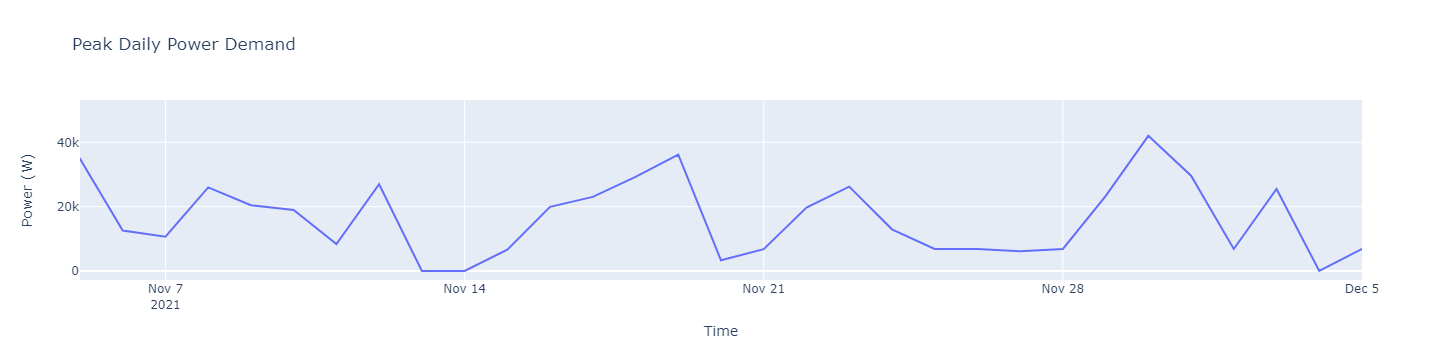

In [101]:
def display_selected_time(start_date, end_date):
    if start_date == None and end_date == None:
        fig = go.Figure()
        fig.add_trace(go.Scatter(x = df_24h.index, y = df_24h["max_power"], name = "Daily Peak Power" , hovertext=df_24h["day"]))
        fig.update_layout(title = f"Peak Daily Power Demand", xaxis_title = "Time", yaxis_title="Power (W)")
        return fig
    print(start_date)
    print(end_date)
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x = df_24h.index, y = df_24h["max_power"] , 
                   name = "Daily Peak Power" , hovertext=df_24h["day"])
    )
    fig.update_layout(title = f"Peak Daily Power Demand", xaxis_title = "Time", yaxis_title="Power (W)", xaxis=dict(range=["2021-11-05", "2021-12-05"]))
    return fig
display_selected_time("2020-11-05", "2020-12-05")

In [11]:
import pandas as pd
import time

original = pd.read_csv("data/slrpEV11052020-09222022.csv")

#1
pattern = r"(\[?\{'power_W':\sDecimal\(')|('timestamp':\sDecimal\(')|('\)\}?\]?)"
power_and_time = original["power"].str.replace(pattern , "" , regex = True) # remove all pattern instances 

#2
power_and_time = power_and_time.str.split(', ')
power_and_time = power_and_time.apply(lambda lst : [int(val) for val in lst]) # cast all str value to int

power_vals = power_and_time.apply(lambda x : x[::2])
time_vals = power_and_time.apply(lambda x : x[1::2])
power_vals = power_vals.explode()
time_vals = time_vals.explode()

def round_format_UNIX_time(time_value):
    """Function takes in a UNIX time value, and rounds this value up 5 minutes.
    The time value is then converted into the format year-month-day hour:minute."""
    
    # round time up 5 minutes 
    time_value = time_value // (5 * 60) * (5*60) + (5*60)
    
    # format time value
    time_value = time.strftime('%Y-%m-%d %H:%M', time.localtime(time_value))
    
    return time_value 

time_vals = time_vals.apply(round_format_UNIX_time)
temp_df = pd.DataFrame({"time" : time_vals , "power_5m" : power_vals}) 
df = original.join(temp_df)
df_power_time = df[["time" , "power_5m"]]
df_power_time = df_power_time.groupby("time").agg(sum)
df_power_time = df_power_time.sort_values(by = "time")
df_power_time.index = pd.to_datetime(df_power_time.index)
df_power_time = df_power_time.resample("5min").sum()

from sklearn.preprocessing import OneHotEncoder

# add a new column with the name of the day of the week 
df_power_time["day"] = df_power_time.index.day_name()

def ohe_day_name(data):
    """This function takes in dataframe with a column 'day', which consists of the name of the day of the week, and one-hot encodes
    the day of the week."""
    oh_enc = OneHotEncoder()
    temp = pd.DataFrame(oh_enc.fit_transform(data[["day"]]).toarray() , columns = oh_enc.get_feature_names_out() , index = df_power_time.index)
    return pd.concat([df_power_time , temp] , axis = 1)

df_power_time = ohe_day_name(df_power_time)

# rename and reorder columns 
df_power_time.rename(columns = {"day_Friday":"Friday", "day_Monday":"Monday",
                                                "day_Saturday":"Saturday", "day_Sunday":"Sunday" ,
                                                "day_Thursday":"Thursday", "day_Tuesday":"Tuesday",
                                                "day_Wednesday":"Wednesday"} , inplace = True)
df_power_time = df_power_time[["power_5m", "day", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday" , "Sunday"]]
df_users = df[["userId" , "time"]]
df_users = df_users.groupby("time").agg("count")

# upsample into 5-minute bins 
df_users.index = pd.to_datetime(df_users.index)
df_users = df_users.resample("5min").sum()
df_users.rename(columns = {'userId':'Connected Users'}, inplace = True)
df_power_time = df_power_time.join(df_users)
df_24h = df_power_time.resample("24h").max()
df_24h.rename(columns = {"power_5m" : "max_power"} , inplace = True)

import plotly.graph_objects as go

def plot_daily_peak_power():
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(x = df_24h.index, y = df_24h["max_power"] , name = "Daily Peak Power" , hovertext=df_24h["day"])
    )
    fig.update_layout(title = f"Peak Daily Power Demand", xaxis_title = "Time", yaxis_title="Power (W)")
    return fig

In [25]:
from datetime import datetime
from datetime import date
import pytz

tz_CA = pytz.timezone('US/Pacific') 
datetime_CA = datetime.now(tz_CA)
print("CA time:", datetime_CA.strftime("%H:%M:%S"))

CA time: 22:23:06


In [33]:
date(2018,2,3)

datetime.date(2018, 2, 3)

In [32]:
tz_CA.dst()

TypeError: dst() missing 1 required positional argument: 'dt'